In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TemporalFusionTransformer import TemporalFusionTransformer

In [2]:
import torch.utils
import torch.utils.data


lookback = 30
future_steps = 20
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 16

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)


### Optional: shuffle the dataset

In [4]:
# import random
# random.shuffle(ds.dataset)

In [3]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data()

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)


feature_dim = ds.feature_dim
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'start_station_X', 'start_station_Y', 'end_station_X',
       'end_station_Y', 'distance_from_start_station_X',
       'distance_from_start_station_Y', 'distance_from_end_station_X',
       'distance_from_end_station_Y', 'facing_start_station',
       'facing_end_station', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'AGV_name',
       'looking_at_closest_station', 'rolling_avg'],
      dtype='object') 
feature_dim : 32


In [4]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([16, 30, 32]) torch.Size([16, 30, 32])
4334 482


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

model = TemporalFusionTransformer(num_features=feature_dim, 
                                  num_hidden=128, num_outputs=2, 
                                  num_steps=lookback)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)


model.to(device)


Using cuda


TemporalFusionTransformer(
  (encoder_grn): GatedResidualNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=32, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=128, bias=True)
  )
  (transformer_block): TransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (feed_forward): Sequential(
      (0): Linear(in_features=128, 

### Customized Loss Function

In [11]:

class DecayLoss(nn.Module):
    def __init__(self, num_steps):
        super(DecayLoss, self).__init__()
        # Weight decreases as we move further into the future
        self.weights = torch.linspace(1.0, 0.9, num_steps)

    def forward(self, predictions, targets):
        loss = 0
        for i in range(predictions.shape[1]):
            loss += self.weights[i] * F.mse_loss(predictions[:, i], targets[:, i])
        return loss
    
baseline_loss_fn = nn.MSELoss()
loss_fn = DecayLoss(future_steps)

In [16]:

n_epochs = 10
eval_step = 5000
save_every = 10000
train_all = len(train)

loss_all = []
now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
os.makedirs(f'../model/{folder_name}', exist_ok=True)


for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)

        loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        loss_all.append(loss.item())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        if (epoch * train_all + step + 1) % save_every == 0:
            print(f"Saving model at epoch {epoch+1}, step {step+1}")

            torch.save(model.state_dict(), f"../model/{folder_name}/model_{epoch * train_all + step + 1}.pt")
        
        if (epoch * train_all + step + 1) % eval_step == 0:
            print(f"Start testing")
            with torch.no_grad():
                model.eval()
                all_test = len(test)
                test_rmse_all = []
                for X_test_batch, y_test_batch in test:
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())

                print("Steps %d: test RMSE %.4f" % (epoch * train_all + step + 1, sum(test_rmse_all)/all_test))
            
            model.train()
        



  0%|          | 0/4334 [00:00<?, ?it/s]

  0%|          | 0/4334 [00:00<?, ?it/s]

Start testing
Steps 5000: test RMSE 0.0511


  0%|          | 0/4334 [00:00<?, ?it/s]

Saving model at epoch 3, step 1332
Start testing
Steps 10000: test RMSE 0.0681


  0%|          | 0/4334 [00:00<?, ?it/s]

Start testing
Steps 15000: test RMSE 0.0564


  0%|          | 0/4334 [00:00<?, ?it/s]

Saving model at epoch 5, step 2664
Start testing
Steps 20000: test RMSE 0.0497


  0%|          | 0/4334 [00:00<?, ?it/s]

Start testing
Steps 25000: test RMSE 0.0414


  0%|          | 0/4334 [00:00<?, ?it/s]

Saving model at epoch 7, step 3996
Start testing
Steps 30000: test RMSE 0.0481


  0%|          | 0/4334 [00:00<?, ?it/s]

  0%|          | 0/4334 [00:00<?, ?it/s]

Start testing
Steps 35000: test RMSE 0.0571


  0%|          | 0/4334 [00:00<?, ?it/s]

Saving model at epoch 10, step 994
Start testing
Steps 40000: test RMSE 0.0568


In [20]:
validation_step = 20

predictions = []
truths = []

with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        y_pred = model(X_test_batch)
        predictions.append(y_pred[:, :validation_step, :2])
        truths.append(y_test_batch[:, :validation_step, :2])
        
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/482 [00:00<?, ?it/s]

In [21]:
# reverse normalization
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

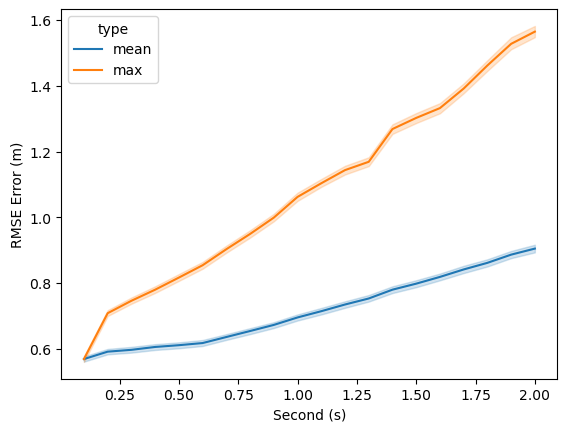

In [22]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, 21):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type')
plt.savefig('../figure/TFT_manual_decay_loss_shuffle.png')
plt.show()

### Export JIT Model

In [23]:
EXPORT_MODEL = True

# model.load_state_dict(torch.load("../model/Jul09_17-13-09/model_9_528.pt"))

if EXPORT_MODEL:
    model.eval()
    script_module = torch.jit.script(model)
    os.makedirs(f'../model/exported/', exist_ok=True)
    script_module.save(f"../model/exported/model.pt")

### Save data (for interactive visualization)

In [100]:
# test_ds = MyDataset(lookback=lookback)
# all_ds = ds.dataset
# test_ds.dataset = all_ds[len(all_ds)//10 :] # load the last 10% of the data
# X_list, y_list = test_ds.generate_data(return_list=True)


In [102]:
# from torch.utils.data import DataLoader, Dataset, TensorDataset

# normalize_dict = stats_dict
# pred_data = []
# truth_data = []

# for i, (X, y) in enumerate(zip(X_list, y_list)):
#     predictions = model(X.float().to(device))[:, :future_steps, :2]
#     truths = y[:, :future_steps, :2]
    
#     trajectory_id = i
    
#     # reverse normalization
#     for idx, key_ in enumerate(["User_X", "User_Y"]):
#         predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    
#     for group_id in range(predictions.shape[0]):
#         for time_step in range(predictions.shape[1]):
#             pred_x, pred_y = predictions[group_id, time_step]
#             pred_data.append([trajectory_id, group_id, time_step, pred_x.item(), pred_y.item()])

#             truth_x, truth_y = truths[group_id, time_step]
#             truth_data.append([trajectory_id, group_id, time_step, truth_x.item(), truth_y.item()])

    

# pred_df = pd.DataFrame(pred_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# truth_df = pd.DataFrame(truth_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])


In [106]:
# truth_df.to_csv("../data/pred_tra_all.csv")
# pred_df.to_csv("../data/truth_tra_all.csv")